In [6]:
pip! install kaggle


The following command must be run outside of the IPython shell:

    $ pip ! install kaggle

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [1]:
kaggle competitions download -c house-prices-advanced-regression-techniques

SyntaxError: invalid syntax (<ipython-input-1-1cca48ebbb57>, line 1)

In [2]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import itertools
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
import optuna
import os

for dirname, _, filenames in os.walk("/workspaces/Kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_path = os.path.join(dirname, filename)

/workspaces/Kaggle/input/data_description.txt
/workspaces/Kaggle/input/house-prices-advanced-regression-techniques.zip
/workspaces/Kaggle/input/sample_submission.csv
/workspaces/Kaggle/input/test.csv
/workspaces/Kaggle/input/train.csv


In [12]:
df = pd.read_csv(data_path)
print(df.shape)
print(list(df.columns.values))
print([type(df.loc[0, :][x]) for x in list(df.columns.values)])
def data_preparer(df, *, Test = None):
    # 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
    for column in df.columns:
        # dtypeがobjectの場合、文字列の変数
        if df[column].dtype=='O':
            df[column] = df[column].fillna('None')
        # dtypeがint , floatの場合、数字の変数
        else:
            df[column] = df[column].fillna(0)
            
    # データの準備
    noneed_label = "Id"
    Y_label = "SalePrice"
    X_label = list(df.columns.values)
    X_label.remove(noneed_label)

    if Test is None:
        X_label.remove(Y_label)
        Y = df["SalePrice"]
        # 対数変換
        Y = np.log(Y)
    else:
        Y = 0
    
    X = df.loc[:, X_label]
    
    # カテゴリカル変数のindexを記憶
    # 列のデータ型はdtype, 中身の型はtypeで取得する
    ctg_list = []
    for i in range(len(X_label)):
        if df[X_label[i]].dtype=='O':
            ctg_list.append(i)
            # print(i, "categolical", X_label[i])
    # print(X.columns[ctg_list])
    # String型をint型に変換
    for column in X.columns[ctg_list]:
        target_column = X[column]
        le = preprocessing.LabelEncoder()
        le.fit(target_column)
        label_encoded_column = le.transform(target_column)
        X[column] = pd.Series(label_encoded_column).astype('category')
    
    return X, Y, ctg_list

X, Y, ctg_list = data_preparer(df)
print(ctg_list)
X.head()

(1460, 81)
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

[<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'str'>, <class 'numpy.float64'>, <class 'numpy.int64'>, <class 'str'>, <class 'float'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.float64'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.int64'>, <class 'str'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'str'>,

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4
1,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4
2,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4
3,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0
4,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4


Best parameters: {'learning_rate': 0.15, 'num_leaves': 30, 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'max_depth': 5}
Best RMSE: 0.1236


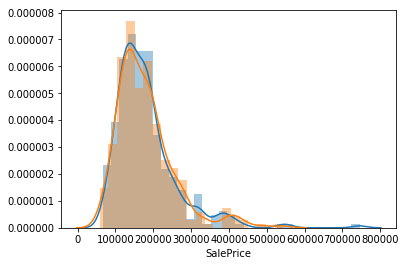

In [13]:
from sklearn.metrics import mean_squared_error
import warnings


def lightgbm_tuning(train_x, train_y, ctg_list):
    # パラメータの探索空間
    param_grid = {
        'learning_rate': [0.1, 0.15, 0.2],
        'num_leaves': [20, 30, 40],
        'boosting_type': ['gbdt'],
        'objective': ['regression'],
        'metric': ['rmse'],
        'max_depth': [3, 5, 7]
    }
    
    # 全ての組み合わせのリストを作成(直積)
    all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]
    
    best_score = float('inf')
    best_params = None
    
    # 各パラメータセットでのモデルの訓練
    for params in all_params:
        # データの分割
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
        
        # モデルの訓練
        train_data = lgb.Dataset(X_train, y_train)
        model = lgb.train(params, train_data, num_boost_round=100, categorical_feature = ctg_list)
        
        # RMSEの計算
        test_preds = model.predict(X_test)
        
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        
        # ベストスコアの更新
        if test_rmse < best_score:
            best_score = test_rmse
            best_params = params
    sns.distplot(np.exp(y_test))
    sns.distplot(np.exp(test_preds))
    print(f"Best parameters: {best_params}")
    print(f"Best RMSE: {best_score:.4f}")
    
    return best_params

def lightgbm_train(params, train_x, train_y, ctg_list):
    
    # モデルの訓練
    train_data = lgb.Dataset(train_x, train_y)
    model = lgb.train(params, train_data, num_boost_round=100, categorical_feature=ctg_list)
    
    return model


warnings.simplefilter('ignore')
best_alpha = lightgbm_tuning(X, Y, ctg_list)
model_lgbm = lightgbm_train(best_alpha, X, Y, ctg_list)

In [24]:
df_sub = pd.read_csv("/workspaces/Kaggle/input/test.csv")
x, y , ctg_list = data_preparer(df_sub, Test = True)
#推論
y_preds = np.exp(model_lgbm.predict(x))

submit = pd.DataFrame(df_sub.loc[:,"Id"])
submit = submit.assign(SalePrice = y_preds)
# submission.csvを出力 
submit.to_csv('../output/submission.csv',index=False) #ノートブックはそのフォルダで動いてる
